In [1]:
! pip install folium
! pip install wordcloud

#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#Fetaure Selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#Modelling Algoritm
from sklearn.cluster import KMeans, MiniBatchKMeans

import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
import requests
import json

from wordcloud import WordCloud

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# 1. Carga de datos

In [2]:
# Cargamos todos los csv en df diferentes
olist_orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('./dataset/olist_products_dataset.csv')
olist_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
olist_payments = pd.read_csv('./dataset/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./dataset/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./dataset/product_category_name_translation.csv')

# Mergeamos los df anteriores en uno solo
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')

# 2. PREPROCESAMIENTO DE DATOS 

In [3]:
all_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2017-08-28 00:00:00            1.0   
4           2017-08-15 00:00:00            1.0   

                         product_id  ... product_height_cm product_width_cm  \
0  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
1  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
2  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
3  87285b34884572647811a353c7ac498a  ...               8.0             13.0   
4  87285b34884572647811a353c7ac498a  ...               8.0             13.0   

                 customer_unique_id  customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366      sao paulo   
4  ef0996a1a279c26e7ecbd737be23d235                      2290      sao paulo   

  customer_state  seller_zip_code_prefix  seller_city seller_state  \
0             SP                    9350         maua           SP   
1             SP                    9350         maua           SP   
2             SP                    9350         maua           SP   
3             SP                    9350         maua           SP   
4             SP                    9350         maua           SP   

   product_category_name_english  
0                     housewares  
1                     housewares  
2                     housewares  
3                     housewares  
4                     housewares  

[5 rows x 40 columns]

In [4]:
all_data.describe()

order_item_id          price  freight_value  payment_sequential  \
count  116581.000000  116581.000000  116581.000000       116581.000000   
mean        1.196953     120.751369      20.062550            1.093369   
std         0.701350     183.848421      15.845515            0.727240   
min         1.000000       0.850000       0.000000            1.000000   
25%         1.000000      39.900000      13.080000            1.000000   
50%         1.000000      74.900000      16.320000            1.000000   
75%         1.000000     134.900000      21.220000            1.000000   
max        21.000000    6735.000000     409.680000           29.000000   

       payment_installments  payment_value   review_score  \
count         116581.000000  116581.000000  116581.000000   
mean               2.949614     172.910258       4.017507   
std                2.783798     267.622516       1.397886   
min                0.000000       0.000000       1.000000   
25%                1.000000      61.000000       4.000000   
50%                2.000000     108.190000       5.000000   
75%                4.000000     189.720000       5.000000   
max               24.000000   13664.080000       5.000000   

       product_name_lenght  product_description_lenght  product_photos_qty  \
count        116581.000000               116581.000000       116581.000000   
mean             48.766317                  785.949331            2.204991   
std              10.033728                  652.614023            1.717417   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  346.000000            1.000000   
50%              52.000000                  600.000000            1.000000   
75%              57.000000                  983.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     116580.000000       116580.00000      116580.000000   
mean        2115.560422           30.31858          16.645891   
std         3783.587898           16.22276          13.474741   
min            0.000000            7.00000           2.000000   
25%          300.000000           18.00000           8.000000   
50%          700.000000           25.00000          13.000000   
75%         1800.000000           38.00000          20.000000   
max        40425.000000          105.00000         105.000000   

       product_width_cm  customer_zip_code_prefix  seller_zip_code_prefix  
count     116580.000000             116581.000000           116581.000000  
mean          23.116898              35053.391556            24504.889030  
std           11.758687              29817.864821            27625.157426  
min            6.000000               1003.000000             1001.000000  
25%           15.000000              11310.000000             6429.000000  
50%           20.000000              24315.000000            13690.000000  
75%           30.000000              58600.000000            28495.000000  
max          118.000000              99980.000000            99730.000000

## 2.1 Manejo variable

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada y buscar y eliminar datos duplicados.



In [5]:
# Vemos los tipos de datos de las columnans 
all_data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
product_category

In [6]:
all_data['order_purchase_timestamp'].dtype

dtype('O')

In [7]:
# Casteamos las siguientes columnas que contiene números a int64
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

In [8]:
# Casteamos las columnas que contienen fechas a datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [9]:
# Ver si hay datos duplicados
print('Duplicados: ',all_data.duplicated().sum())

Duplicados:  0


## 2.2 Manejo de valores perdidos

Esta etapa se hace para eliminar entradas vacías mediante el uso de otras características o el reemplazando este volor perdido por la media / mediana.

In [10]:
# Vemos qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [11]:
# Gestion de las entradas vacías en la columna order_approved_at
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at'].fillna(add_1, inplace=True)

count                       116567
mean     0 days 10:30:07.890517899
std      0 days 22:14:31.829017333
min                0 days 00:00:00
25%                0 days 00:12:57
50%                0 days 00:20:52
75%         0 days 14:58:55.500000
max               60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:52


In [12]:
# Gestion de las entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date'].fillna(add_2, inplace=True)


count                       115368
mean     2 days 20:23:21.823928645
std      3 days 13:29:23.374800010
min            -172 days +18:44:38
25%                0 days 21:15:35
50%                1 days 20:16:53
75%                3 days 15:25:20
max              107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:16:53


In [13]:
# Gestion de las entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date'].fillna(add_3, inplace=True)

count                       114066
mean     9 days 04:55:20.323251451
std      8 days 15:13:53.022396847
min             -17 days +21:41:31
25%                4 days 01:35:44
50%                7 days 01:30:53
75%               11 days 22:21:44
max              205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:30:53


In [14]:
# El número de celdas en blanco en las columnas review_comment_title y review_comment_message es muy grande 
# e imposible de completar. Entonces se eliminan.

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [15]:
# El número de celdas en blanco en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
# es solo una, entonces borramos estos registros
all_data = all_data.dropna()

In [16]:
# Comprueba si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [17]:
all_data.describe()

order_item_id          price  freight_value  payment_sequential  \
count  116580.000000  116580.000000   116580.00000       116580.000000   
mean        1.196955     120.735815       20.06249            1.093369   
std         0.701353     183.772492       15.84557            0.727244   
min         1.000000       0.850000        0.00000            1.000000   
25%         1.000000      39.900000       13.08000            1.000000   
50%         1.000000      74.900000       16.32000            1.000000   
75%         1.000000     134.900000       21.22000            1.000000   
max        21.000000    6735.000000      409.68000           29.000000   

       payment_installments  payment_value   review_score  \
count         116580.000000  116580.000000  116580.000000   
mean               2.949554     172.894920       4.017499   
std                2.783733     267.572419       1.397889   
min                0.000000       0.000000       1.000000   
25%                1.000000      61.000000       4.000000   
50%                2.000000     108.190000       5.000000   
75%                4.000000     189.720000       5.000000   
max               24.000000   13664.080000       5.000000   

       product_name_lenght  product_description_lenght  product_photos_qty  \
count        116580.000000               116580.000000       116580.000000   
mean             48.766221                  785.948653            2.204984   
std              10.033717                  652.616781            1.717423   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  346.000000            1.000000   
50%              52.000000                  600.000000            1.000000   
75%              57.000000                  983.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     116580.000000       116580.00000      116580.000000   
mean        2115.560422           30.31858          16.645891   
std         3783.587898           16.22276          13.474741   
min            0.000000            7.00000           2.000000   
25%          300.000000           18.00000           8.000000   
50%          700.000000           25.00000          13.000000   
75%         1800.000000           38.00000          20.000000   
max        40425.000000          105.00000         105.000000   

       product_width_cm  customer_zip_code_prefix  seller_zip_code_prefix  
count     116580.000000             116580.000000           116580.000000  
mean          23.116898              35052.918863            24504.361366  
std           11.758687              29817.555905            27624.688399  
min            6.000000               1003.000000             1001.000000  
25%           15.000000              11310.000000             6429.000000  
50%           20.000000              24315.000000            13690.000000  
75%           30.000000              58600.000000            28495.000000  
max          118.000000              99980.000000            99730.000000

## 2.3. Extracción de características 

En esta etapa crearemos nuevas caracteristicas a partir de las columnas existentes. 



In [18]:
# Creamos una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta
# que los artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [19]:
# Creamos una columna order_delivery_time para ver cuánto tiempo se requiere de envío para cada pedido
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [20]:
# Creamos una columna order_time_accuracy para ver la diferencia entre el tiempo estimado de envio y el tiempo que 
# realmente demoro. Si el valor es positivo entonces es más rápido hasta, si es cero, está justo a tiempo 
# y si es negativo llego tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [21]:
# Creamos una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [22]:
# Creamos una columna review_send_time para averiguar cuánto tiempo se envió la encuesta de satisfacción después de recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [23]:
# Creamos una columna review_answer_time 
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [24]:
# Convinamos las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

In [25]:
all_data['product_volume'].nunique()

4487

In [26]:
all_data['order_process_time'].mean()

Timedelta('12 days 10:27:13.057325441')

In [27]:
# Creamos una columna month_order para la exploración de datos
all_data['month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')
all_data[['month_order','order_purchase_timestamp']].head()

# Nos quedamos con las columnas que van desde 01-2017 hasta 08-2018
# Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 
# y después del 08-2018 basado en datos de compra / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [28]:
# Datos para geovisualización
df_orders_items = olist_orders.merge(olist_customers, how='left', on='customer_id')

# Utilizamos API del gobierno de Brasil 
requests_result = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
uf = [mesorregion['UF'] for mesorregion in json.loads(requests_result.text)]

br_info = pd.DataFrame(uf)
br_info['customer_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# El lugar más al norte de Brasil está en 5 deg 16′ 27.8″ N lat
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# El lugar más occidental está en 73 deg, 58′ 58.19″W long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
# EL lugar mas al sur esta en 33 deg, 45′ 04.21″ S lat
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
# Su lugar más oriental esta 34 deg, 47′ 35.33″ W long
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')

all_data = pd.merge(all_data, df_orders_items[['customer_id','customer_regiao']], on ='customer_id')

all_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2017-08-28              1   
4                    2017-08-15              1   

                         product_id  ... product_category_name_english  \
0  87285b34884572647811a353c7ac498a  ...                    housewares   
1  87285b34884572647811a353c7ac498a  ...                    housewares   
2  87285b34884572647811a353c7ac498a  ...                    housewares   
3  87285b34884572647811a353c7ac498a  ...                    housewares   
4  87285b34884572647811a353c7ac498a  ...                    housewares   

  order_process_time  order_delivery_time  order_accuracy_time  \
0    8 days 10:28:40      6 days 01:30:13      7 days 02:34:47   
1    8 days 10:28:40      6 days 01:30:13      7 days 02:34:47   
2    8 days 10:28:40      6 days 01:30:13      7 days 02:34:47   
3    2 days 20:15:12      0 days 23:16:10      9 days 09:15:17   
4    5 days 00:05:14      3 days 00:54:18      7 days 05:29:59   

   order_approved_time review_send_time  review_answer_time  product_volume  \
0      0 days 00:10:42  0 days 02:34:47     1 days 03:43:48          1976.0   
1      0 days 00:10:42  0 days 02:34:47     1 days 03:43:48          1976.0   
2      0 days 00:10:42  0 days 02:34:47     1 days 03:43:48          1976.0   
3      0 days 01:35:45  0 days 09:15:17     1 days 15:16:36          1976.0   
4      0 days 00:18:28  0 days 05:29:59     0 days 23:26:23          1976.0   

  month_order  customer_regiao  
0     2017-10          Sudeste  
1     2017-10          Sudeste  
2     2017-10          Sudeste  
3     2017-08          Sudeste  
4     2017-08          Sudeste  

[5 rows x 47 columns]

# 3. EDA (Exploratory Data Analysis)

En esta etapa se lleva a cabo la exploración de datos para obtener información que puede ser útil para la empresa.

## 3.1 ¿Qué productos tienen más demanda?

Text(0, 0.5, 'Categoria del producto')

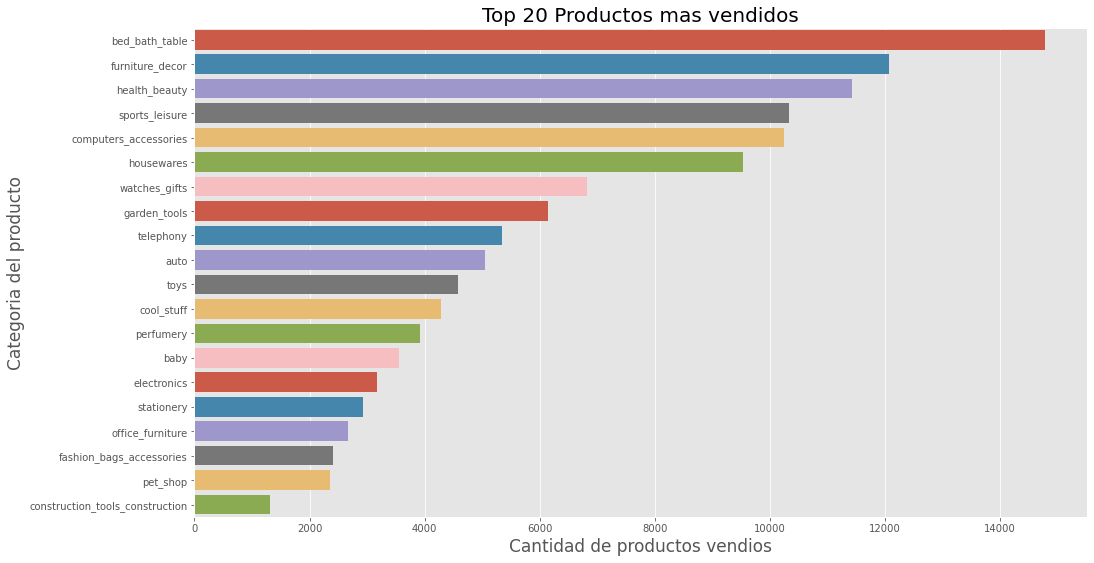

In [29]:
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values,palette=sns.color_palette())
plt.title('Top 20 Productos mas vendidos',fontsize=20)
plt.xlabel('Cantidad de productos vendios',fontsize=17)
plt.ylabel('Categoria del producto',fontsize=17)

##  3.2 ¿Quién es el cliente que compro mayor cantidad de productos?

Text(0, 0.5, 'Customer ID')

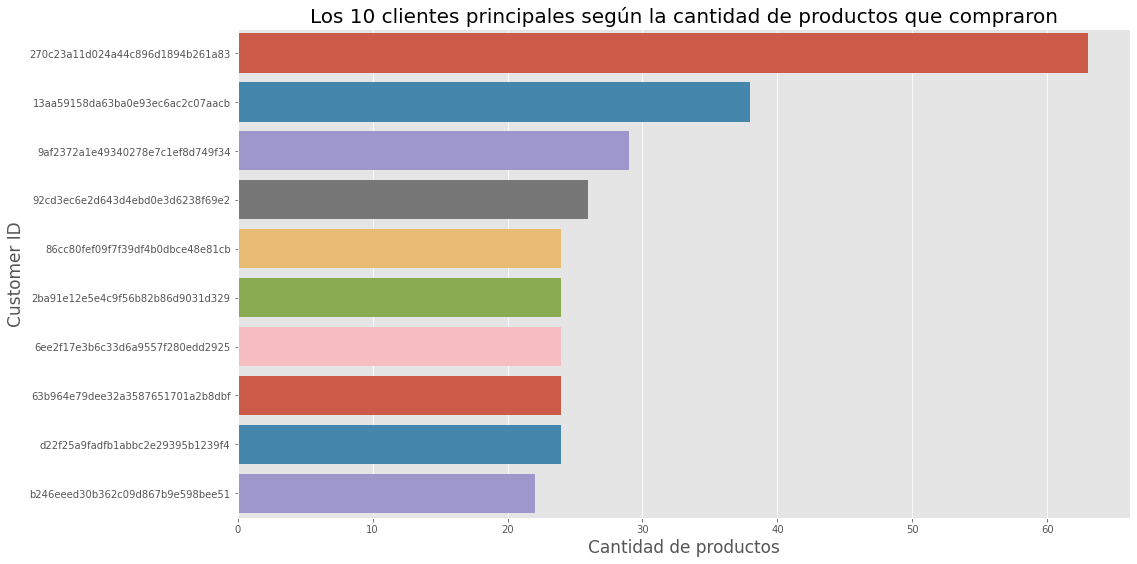

In [30]:
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values,palette=sns.color_palette())
plt.title('Los 10 clientes principales según la cantidad de productos que compraron',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

## 3.3 ¿Quién es el cliente que más gasto?

Text(0, 0.5, 'Customer ID')

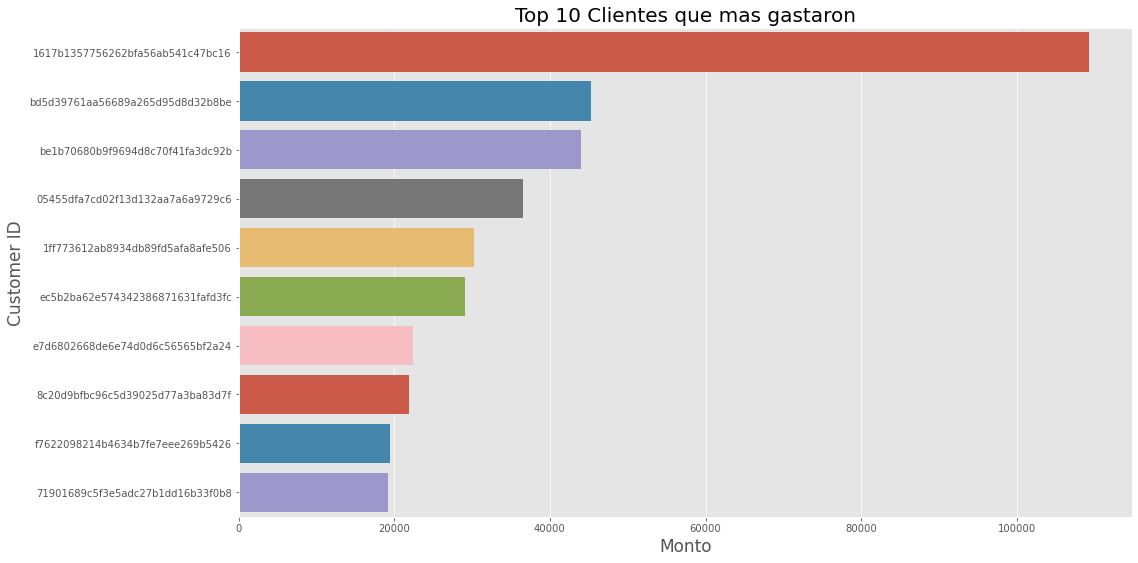

In [31]:
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values,palette=sns.color_palette())
plt.title('Top 10 Clientes que mas gastaron',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

## 3.4 ¿Qué vendedores tienen mas ventas realizadas?

Text(0, 0.5, 'Seller ID')

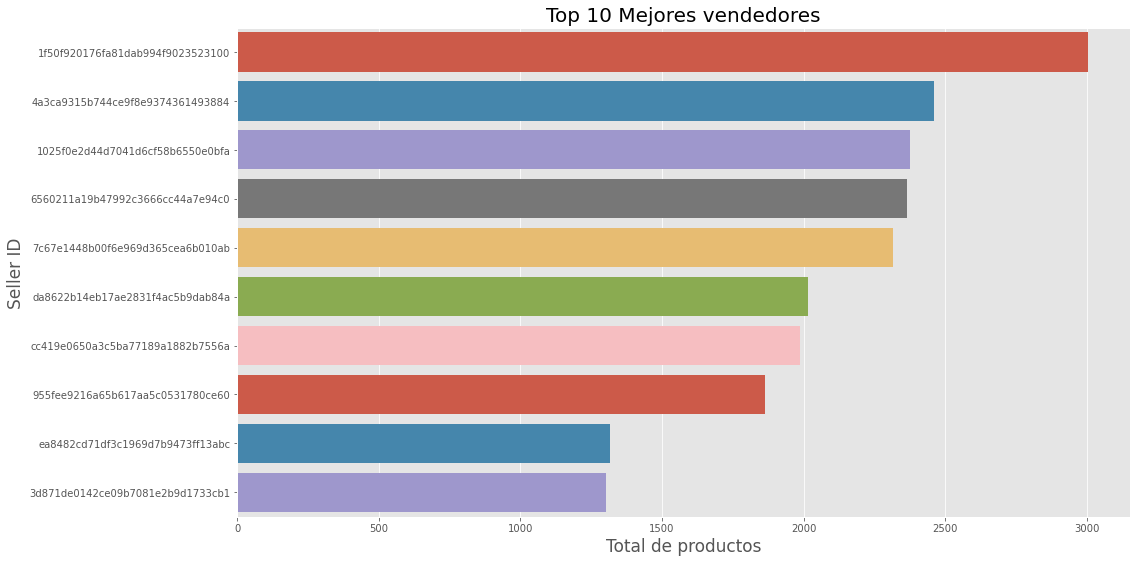

In [32]:
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values,palette=sns.color_palette())
plt.title('Top 10 Mejores vendedores',fontsize=20)
plt.xlabel('Total de productos',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.5 ¿Cuál es el vendedor con mayores ingresos?

Text(0, 0.5, 'Seller ID')

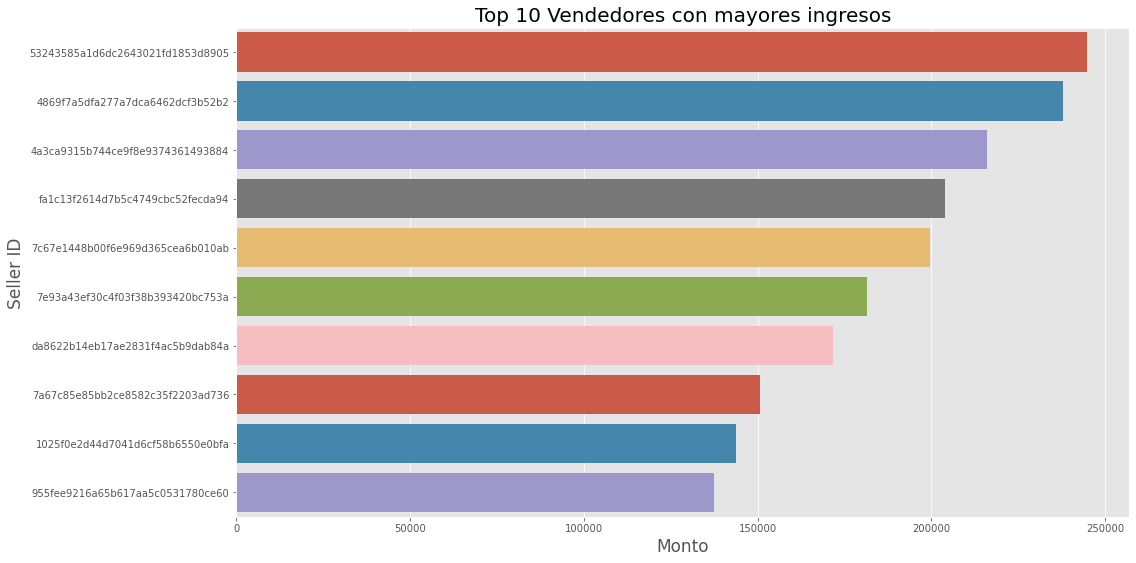

In [33]:
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mayores ingresos',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.6 ¿Cuál es el vendedor que mas ingresos tuvo por score ?

Text(0, 0.5, 'Seller ID')

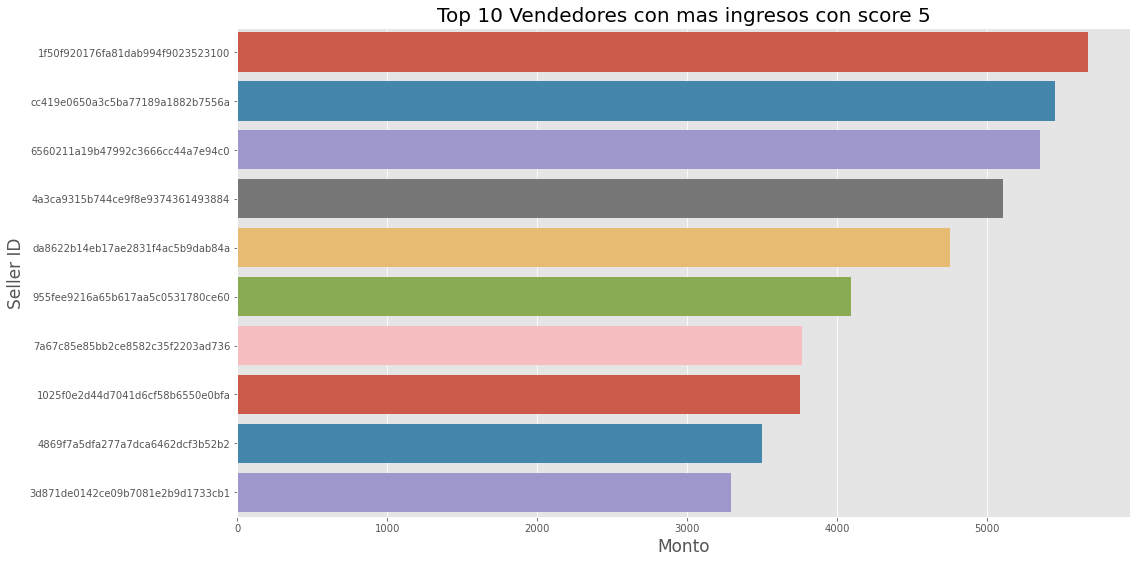

In [34]:
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 5',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

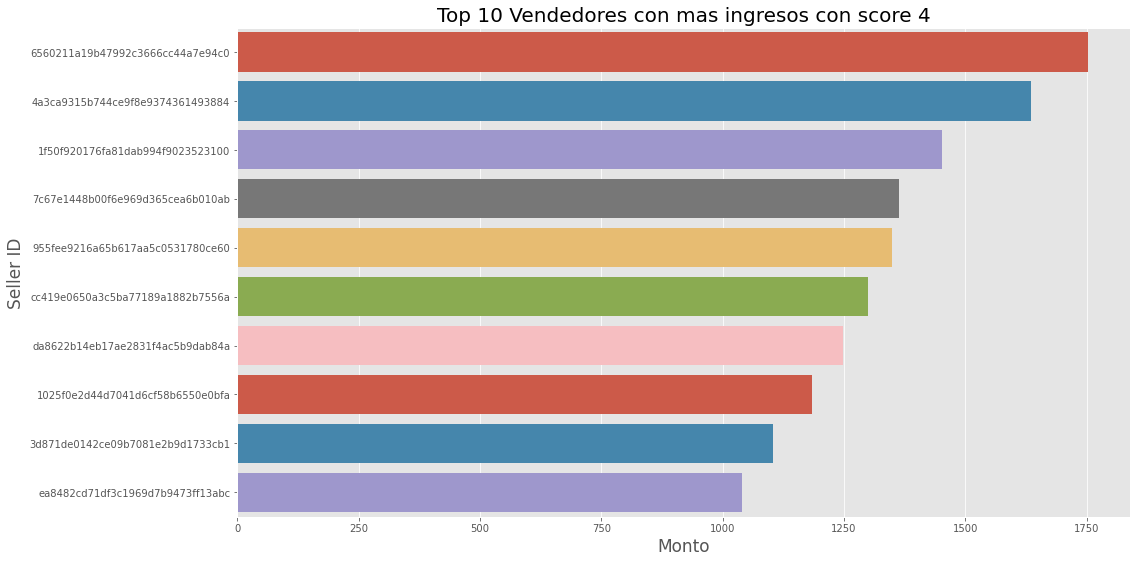

In [35]:
top_10_seller_order = all_data[all_data['review_score'] == 4].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 4',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

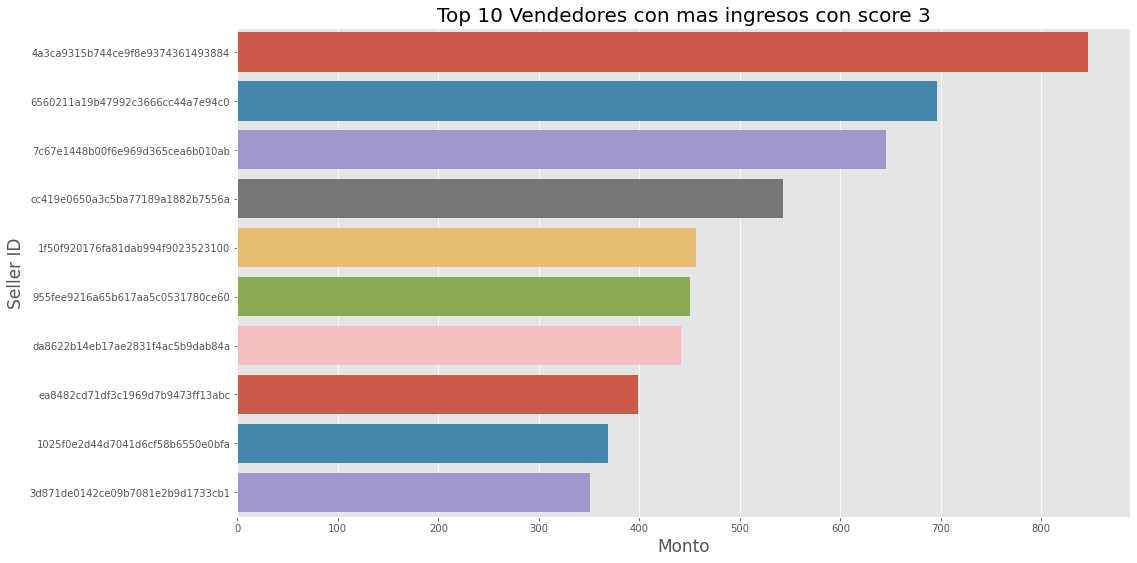

In [36]:
top_10_seller_order = all_data[all_data['review_score'] == 3].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score, palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 3',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

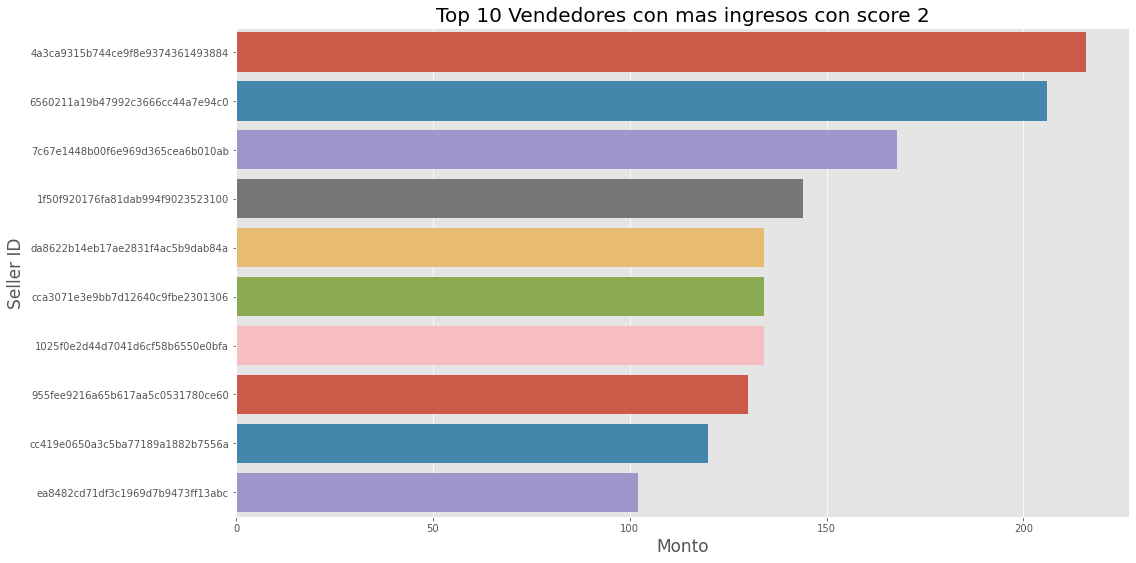

In [37]:
top_10_seller_order = all_data[all_data['review_score'] == 2].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 2',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

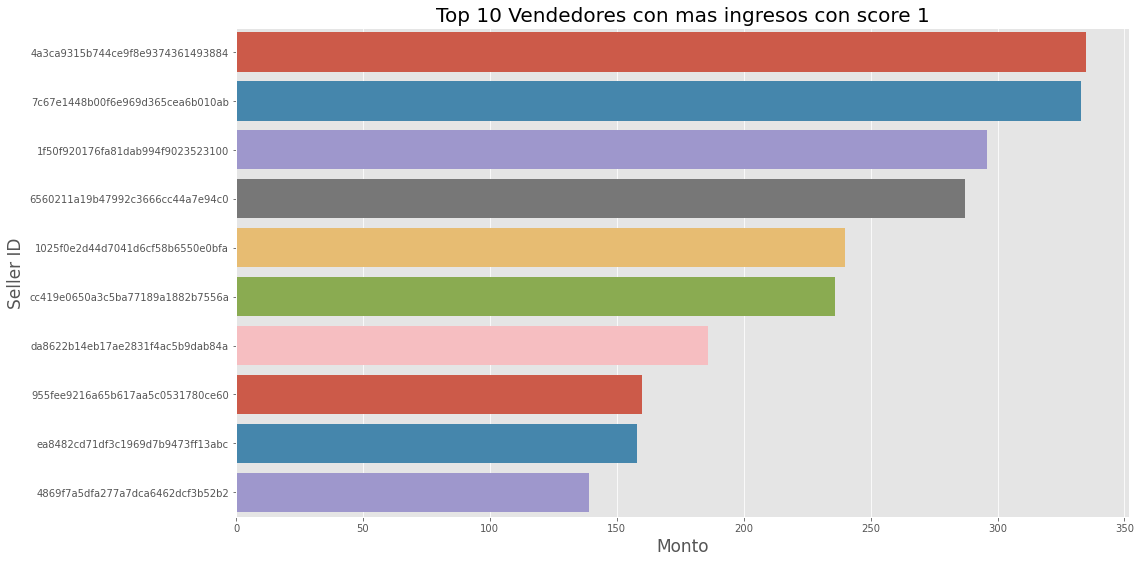

In [38]:
top_10_seller_order = all_data[all_data['review_score'] == 1].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 1',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.7 ¿Cuál es el tiempo promedio de proceso del pedido por mes?

Text(0, 0.5, 'Dias')

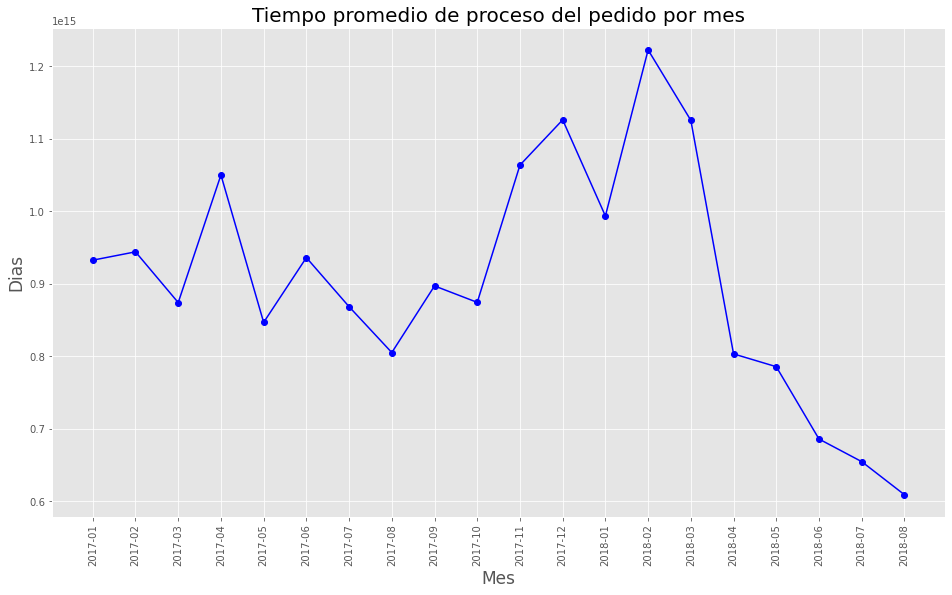

In [39]:
order_time_by_month = all_data['order_process_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o',color="blue")
plt.title('Tiempo promedio de proceso del pedido por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Dias',fontsize=17)

## 3.8 ¿Cuál es el tiempo de entrega promedio por mes?

Text(0, 0.5, 'Dias')

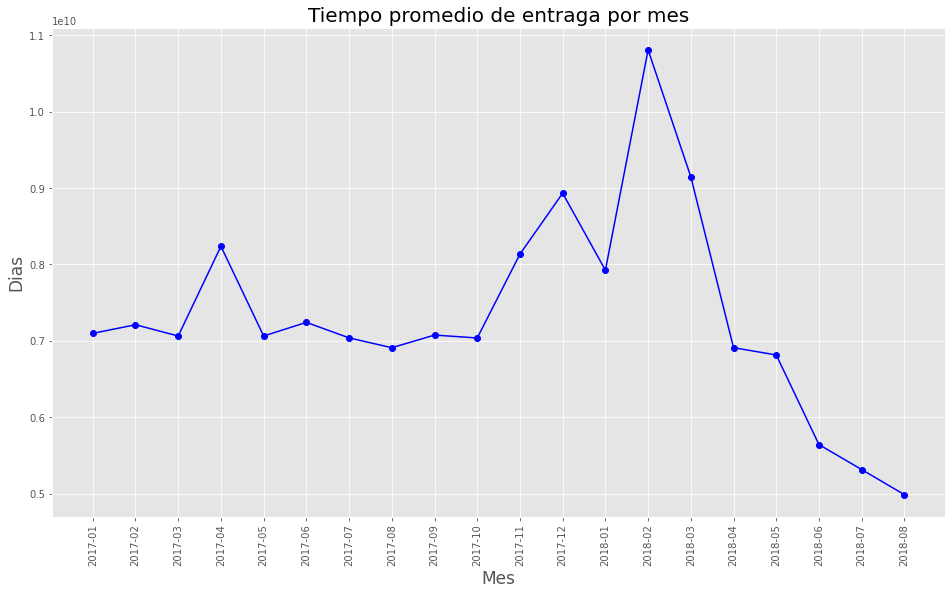

In [40]:
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['month_order']).median(numeric_only=False) 

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o',color="blue")
plt.title('Tiempo promedio de entraga por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Dias',fontsize=17)

## 3.9 ¿Cuál es la precisión promedio para la entrega de los envíos por mes?

Text(0, 0.5, 'Time (Day)')

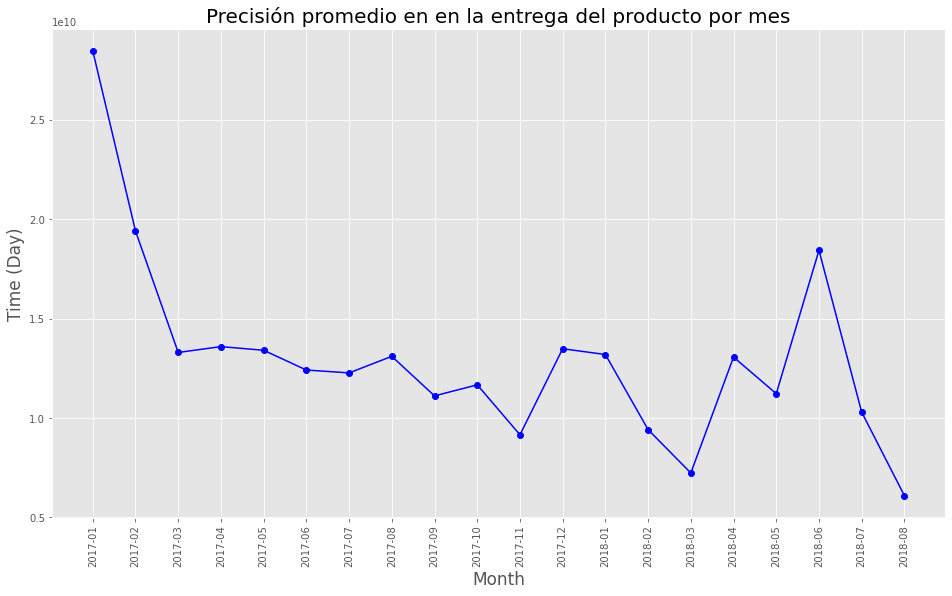

In [41]:
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o',color="blue")
plt.title('Precisión promedio en en la entrega del producto por mes',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

## 3.10 ¿Cuál es el tiempo promedio en el que se aprueba un pedido por mes ?

Text(0, 0.5, 'Minutos')

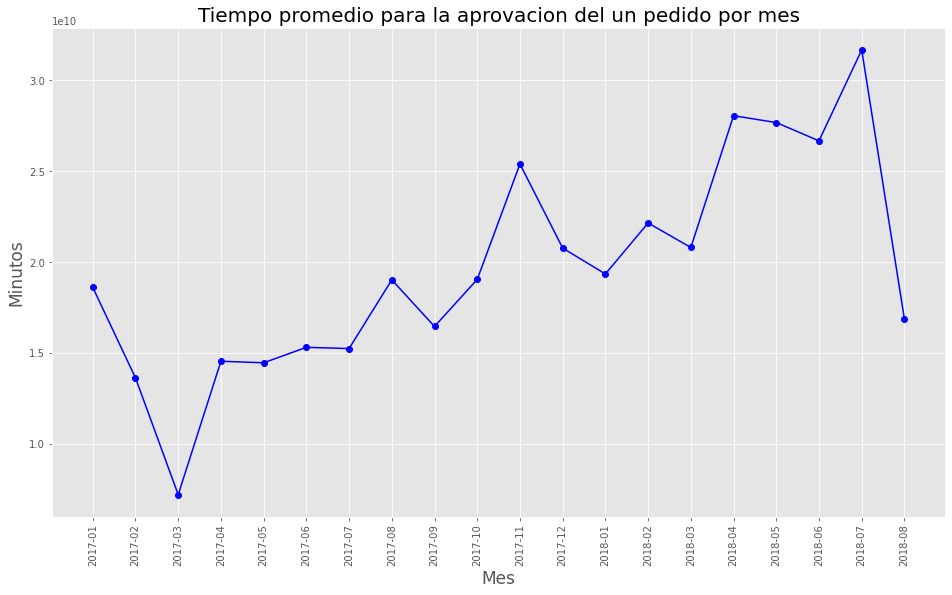

In [42]:
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o',color="blue")
plt.title('Tiempo promedio para la aprovacion del un pedido por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Minutos',fontsize=17)

## 3.11 ¿Cuantos items fueron vendidos por mes?

Text(0, 0.5, 'Monto')

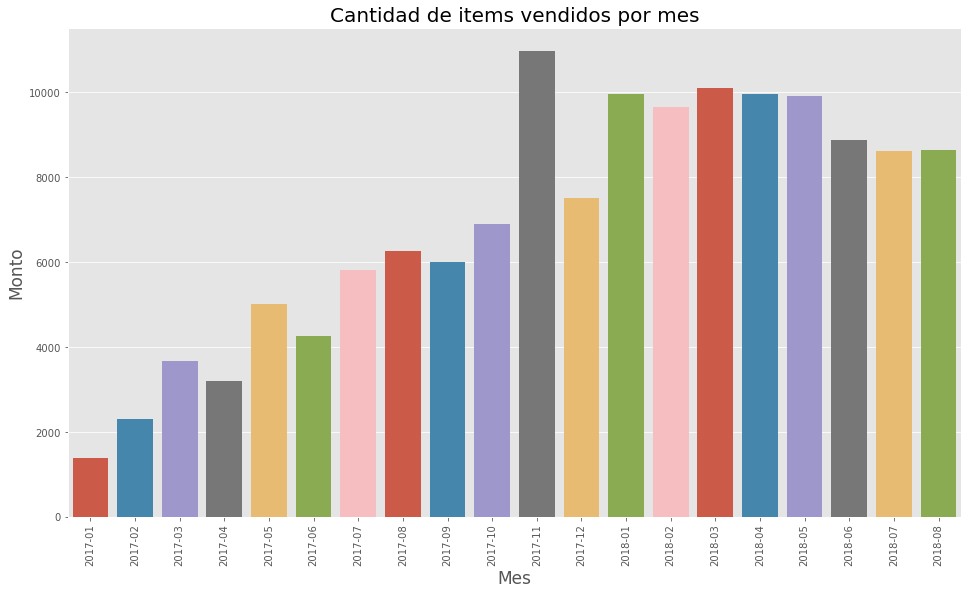

In [43]:
order_count_by_month = all_data['order_item_id'].groupby(all_data['month_order']).sum()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index,palette=sns.color_palette())
plt.title('Cantidad de items vendidos por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Monto',fontsize=17)

## 3.11 ¿Cual fue el monto por transaccion por mes?

Text(0, 0.5, 'Monto')

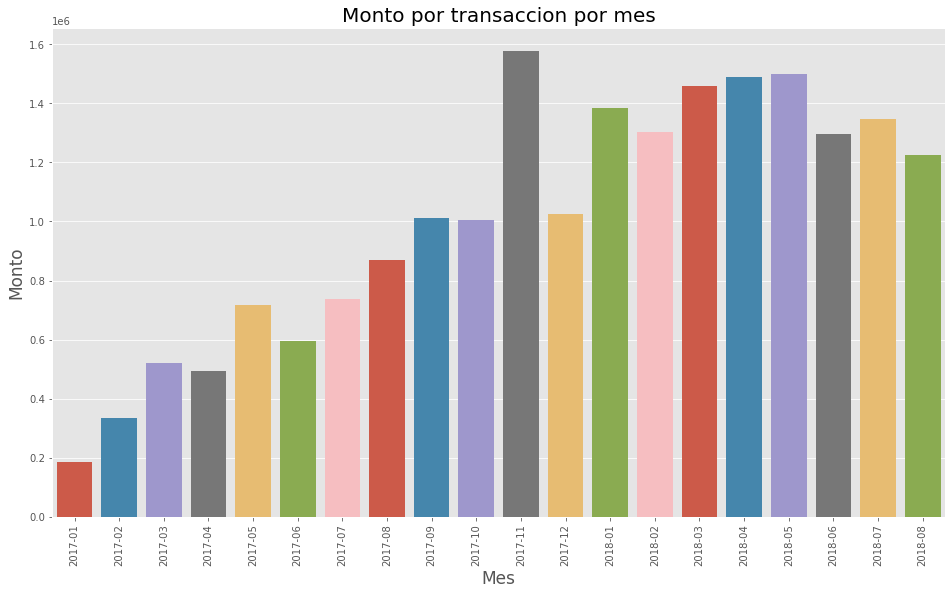

In [44]:
revenue_count_by_month = all_data['payment_value'].groupby(all_data['month_order']).sum()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index,palette=sns.color_palette())
plt.title('Monto por transaccion por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Monto',fontsize=17)

## 3.11 ¿Cuánto usuarios hay activos cada mes?

Text(0, 0.5, 'Cantidad de usuarios')

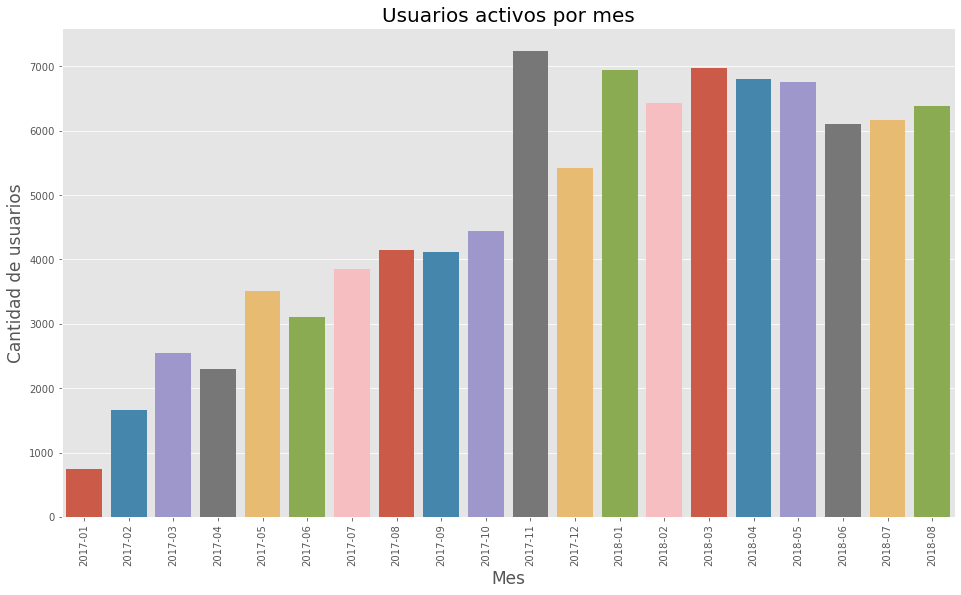

In [45]:
customer_active_by_month = all_data.groupby('month_order')['customer_unique_id'].nunique().reset_index()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['month_order'],palette=sns.color_palette())
plt.title('Usuarios activos por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de usuarios',fontsize=17)

## 3.12 ¿Que ciudades compra mas productos?

Text(0, 0.5, 'Ciudad')

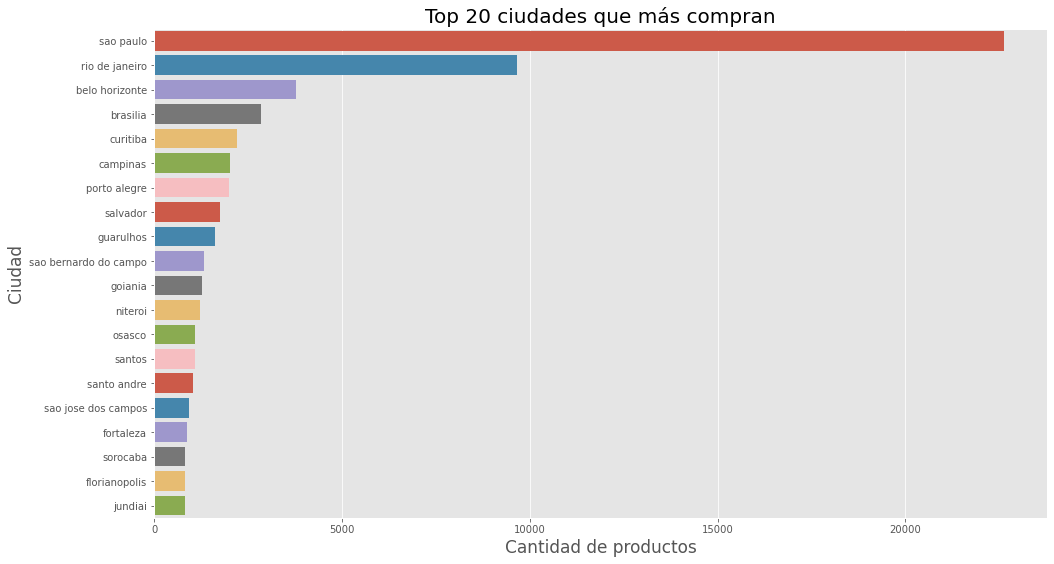

In [46]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values, palette=sns.color_palette())
plt.title('Top 20 ciudades que más compran',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Ciudad',fontsize=17)

## 3.13 ¿Que estados compra mas productos?

Text(0, 0.5, 'Estados')

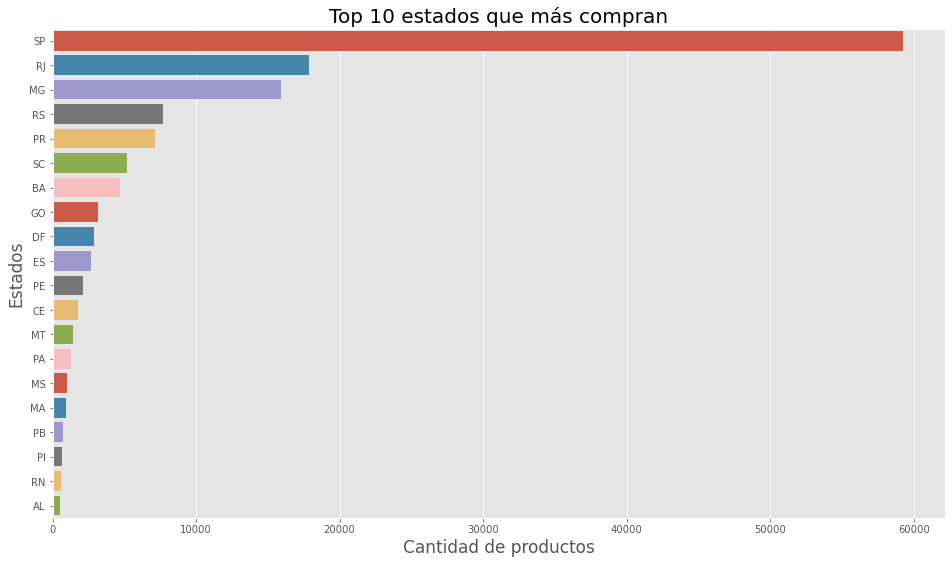

In [47]:
top_10_state = all_data['order_item_id'].groupby(all_data['customer_state']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_state.index,x=top_10_state.values, palette=sns.color_palette())
plt.title('Top 10 estados que más compran',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Estados',fontsize=17)

## 3.14 ¿Que ciudad vende mas?

Text(0, 0.5, 'Ciudad')

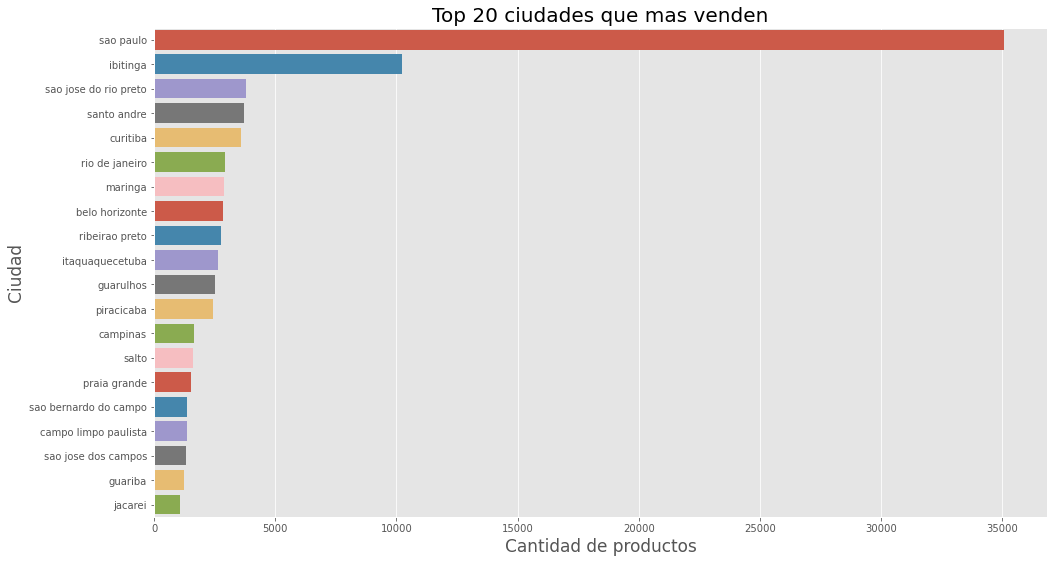

In [48]:
top_20_city_selling = all_data['order_item_id'].groupby(all_data['seller_city']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_selling.index,x=top_20_city_selling.values,palette=sns.color_palette())
plt.title('Top 20 ciudades que mas venden',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Ciudad',fontsize=17)

## 3.15 ¿Que estado vende mas?

Text(0, 0.5, 'Estados')

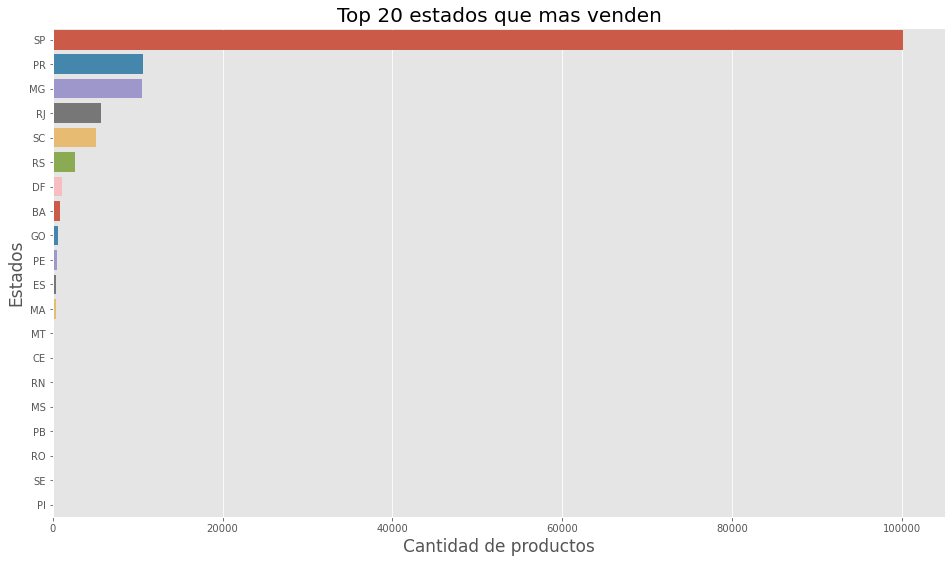

In [49]:
top_20_city_selling = all_data['order_item_id'].groupby(all_data['seller_state']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_selling.index,x=top_20_city_selling.values,palette=sns.color_palette())
plt.title('Top 20 estados que mas venden',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Estados',fontsize=17)

## 3.16 ¿Donde se ubican los clientes?

In [50]:
heat_data = df_orders_items.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:,:3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

map1 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles="OpenStreetMap")

HeatMap(name='Mapa de Calor',data=heat_data,radius=10,max_zoom=13,).add_to(map1)

map1

## 3.17 ¿Donde se ubican los vendedores?

In [51]:
geo = geo_prep.copy()
geo.columns = ['zip_code','geolocation_lat','geolocation_lng','geolocation_city','geolocation_state']

sellers = olist_sellers[['seller_id','seller_zip_code_prefix']]
sellers.columns=['seller_id','zip_code']

sellers_geo = pd.merge(geo, sellers[['seller_id','zip_code']], on='zip_code')
sellers_geo = sellers_geo.drop_duplicates(subset=['seller_id'])

heat_data = sellers_geo.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

map1 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles="OpenStreetMap")

HeatMap(name='Mapa de Calor',data=heat_data,radius=10,max_zoom=13,).add_to(map1)

map1

## 3.18 ¿Cual es el coste medio del envio por region?

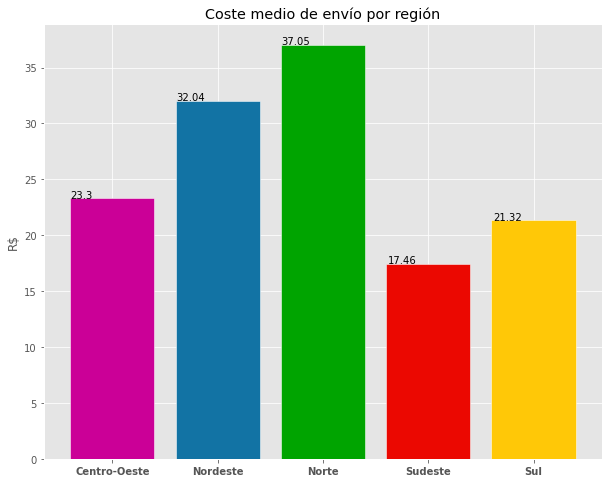

In [52]:
colores = ['#cb0097','#1273a4','#00a400','#eb0801','#ffc807']

plt.figure(figsize=(10,8))
ax = (all_data.groupby('customer_regiao')['freight_value'].mean().round(2)).plot(kind = 'bar', width=0.8,color=colores,edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
   
plt.xlabel('')
plt.ylabel('R$')
plt.title('Coste medio de envío por región')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

## 3.19 ¿Cuales son los medios de pago mas y menos usados?

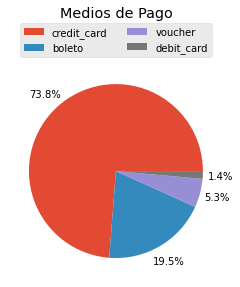

In [53]:
size_of_groups = all_data['payment_type'].value_counts()
labels = all_data['payment_type'].value_counts().index

plt.pie(size_of_groups, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='lower center', bbox_to_anchor=(.5,1),ncol=2, fancybox=True)

plt.title('Medios de Pago', pad=45)
plt.show()

Text(0, 0.5, 'Cuotas')

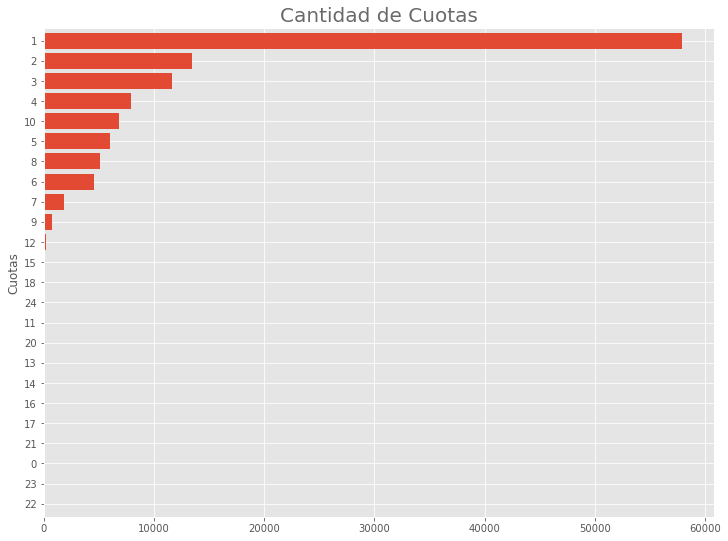

In [54]:
fig= plt.figure(figsize=(12,9))
installments = all_data['payment_installments'].value_counts(ascending=True).plot.barh(width=.8)

plt.title('Cantidad de Cuotas', color='dimgrey', size=20)
plt.ylabel('Cuotas')

## 3.20 Analisis de los reviews de los clientes

<AxesSubplot:>

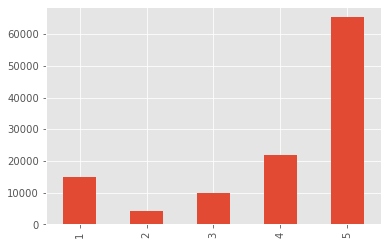

In [55]:
all_data['review_score'].value_counts().sort_index().plot.bar()

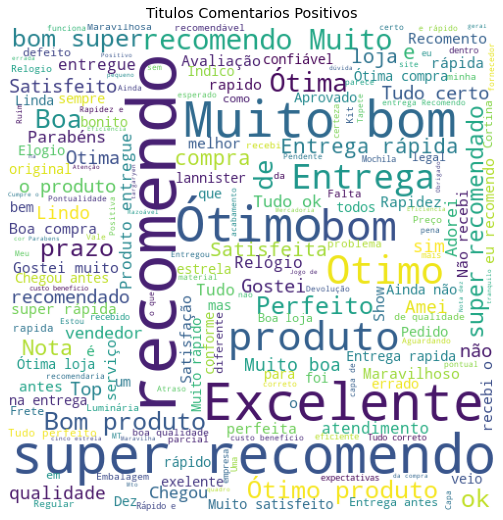

In [56]:
# Titulos de los comentarios positivos
comentario_positivo = olist_reviews.loc[olist_reviews['review_score']>=3].dropna().reset_index()
text = ' '.join(comentario_positivo['review_comment_title'].str.replace('_',' '))

wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)
plt.figure(figsize=(15,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Titulos Comentarios Positivos')
plt.show()

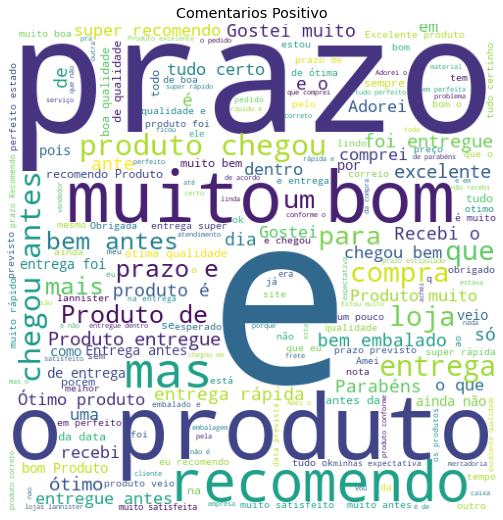

In [57]:
# Comentarios positivos
text = ' '.join(comentario_positivo['review_comment_message'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)

plt.figure(figsize=(15,9))
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Comentarios Positivo')
plt.show()


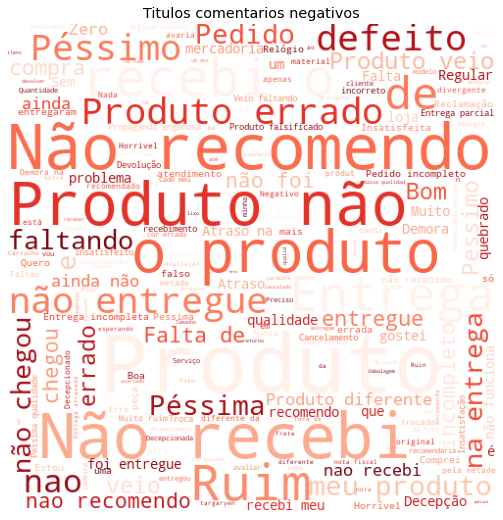

In [58]:
# Titulos de los comentarios negativos
comentario_negativo = olist_reviews.loc[olist_reviews['review_score']<3].dropna().reset_index()

text = ' '.join(comentario_negativo['review_comment_title'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white', colormap="Reds").generate(text)
 
plt.figure(figsize=(15,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Titulos comentarios negativos')
plt.show()

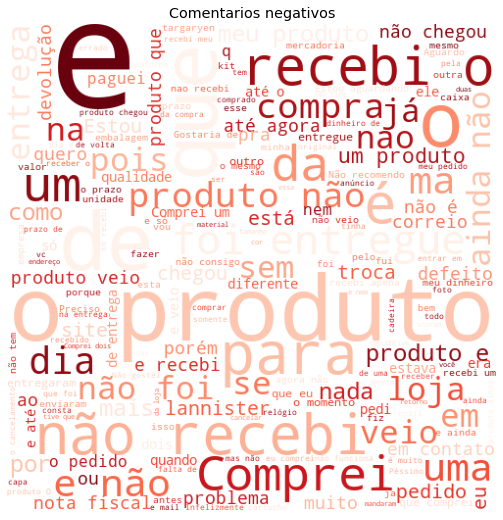

In [59]:
# Comentarios negativos
comentario_negativo = olist_reviews.loc[olist_reviews['review_score']<3].dropna().reset_index()

plt.figure(figsize=(15,9))

text = ' '.join(comentario_negativo['review_comment_message'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white', colormap="Reds").generate(text)
 
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Comentarios negativos')
plt.show()

## 3.20 ¿En que regiones se encuantran los clientes?

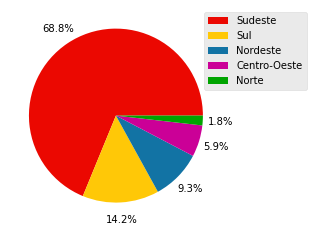

In [60]:
colores = ['#eb0801','#ffc807','#1273a4','#cb0097','#00a400']

size_of_groups = all_data['customer_regiao'].value_counts()
labels = all_data['customer_regiao'].value_counts().index
plt.pie(size_of_groups, colors=colores, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='upper right', bbox_to_anchor=(1.4,1))

plt.show()

## 3.20 ¿Cual es el costo medio del envio por region ?

<AxesSubplot:xlabel='customer_regiao'>

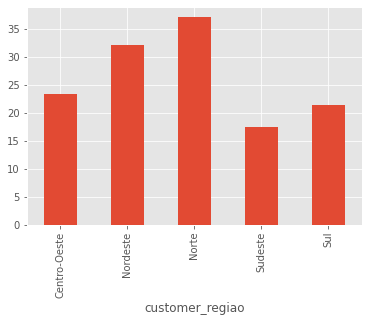

In [61]:
all_data.groupby('customer_regiao')['freight_value'].mean().plot.bar()

# 4. Modelado

Segmentaremos los clientes utilizando k-means con análisis RFM (Recency, Frequency, Monetary value) que es uno de los métodos de segmentación de clientes más sencillos de implantar, y al mismo tiempo uno de los que mejores resultados aportan a corto plazo.

- Recency: ¿Cuándo fue la última vez que un Cliente me compró algo?
- Frecuency: ¿Cuántas veces me ha comprado un Cliente en el periodo de análisis?
- Monetary value: ¿Cuál ha sido el valor monetario agregado de un Cliente en dicho periodo?


## 4.1 Recency, Recency y Monetary value

Deberemos crear estas variables para cada cliente antes de realizar la segmentacion.

In [62]:
df = pd.DataFrame(all_data['customer_id'].unique())
df.columns = ['customer_id']

### 4.1.2 Recency
Para calcular recency, vamos utilizar la delivered order_purchase_timestamp

In [63]:
recency_df = all_data.groupby('customer_id').order_purchase_timestamp.max().reset_index()
recency_df.columns = ['customer_id', 'max_purchase_date']
recency_df['recency'] = (recency_df['max_purchase_date'].max() - recency_df['max_purchase_date']).dt.days
df = pd.merge(df, recency_df[['customer_id','recency', 'max_purchase_date']], on='customer_id')
df.head()

customer_id  recency   max_purchase_date
0  9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33
1  a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31
2  26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47
3  53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46
4  a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28

### 4.1.2 Frequency
Para encontrar frequency, es necesario encontrar el numero total de pedidos para cada cliente.

In [64]:
frequency_df = all_data.groupby('customer_id').order_item_id.count().reset_index()
frequency_df.columns = ['customer_id','frequency']
df = pd.merge(df, frequency_df, on='customer_id')
df.head()

customer_id  recency   max_purchase_date  frequency
0  9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33          3
1  a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31          1
2  26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47          1
3  53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46          1
4  a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28          2

### 4.1.3 Monetary Value
Para encontrar el monetary value sumamos todos los pedidos realizados por cada cliente.

In [65]:
monetary_df = all_data['payment_value'].groupby(all_data['customer_id']).sum().reset_index()
monetary_df.columns = ['customer_id','monetary_value']
df = pd.merge(df, monetary_df, on='customer_id')
df.head()

customer_id  recency   max_purchase_date  frequency  \
0  9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33          3   
1  a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31          1   
2  26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47          1   
3  53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46          1   
4  a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28          2   

   monetary_value  
0           38.71  
1           37.77  
2           37.77  
3           44.09  
4          254.90

## 4.2 RFM Clusters K-means
Aplicaremos el algoritmo K-Means simultaneamente para todas las variables RFM. Pero antes, realizaremos el tratamiento de los outliers através del método IQR.

In [66]:
df_rm = df[['recency', 'monetary_value']]
df_rm.head()

recency  monetary_value
0      331           38.71
1      378           37.77
2      391           37.77
3      309           44.09
4      370          254.90

In [67]:
df_rm.describe()

recency  monetary_value
count  96944.000000    96944.000000
mean     238.017247      207.138952
std      151.491017      626.445194
min        0.000000        9.590000
25%      115.000000       63.000000
50%      219.000000      110.000000
75%      348.000000      197.020000
max      601.000000   109312.640000

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



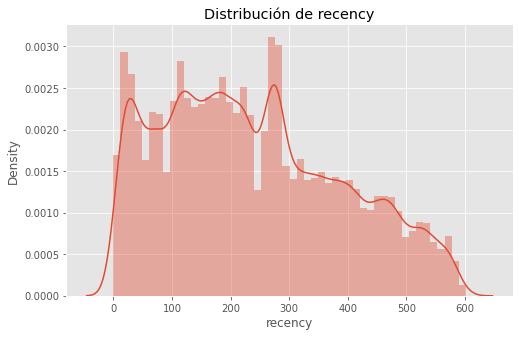

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



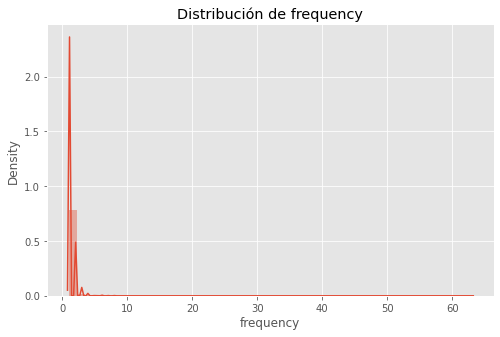

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



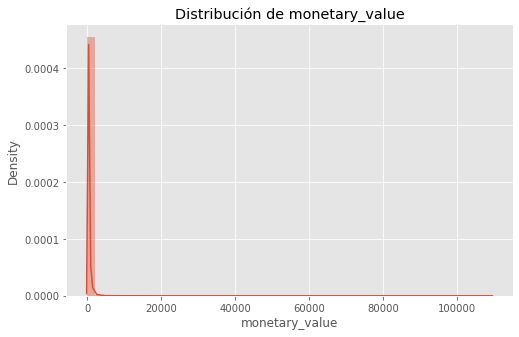

In [68]:
colnames = ['recency', 'frequency', 'monetary_value']

for col in colnames:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.distplot(df[col])
    ax.set_title('Distribución de %s' % col)
    plt.show()


<AxesSubplot:ylabel='Frequency'>

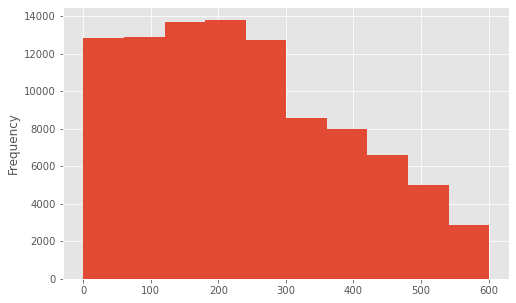

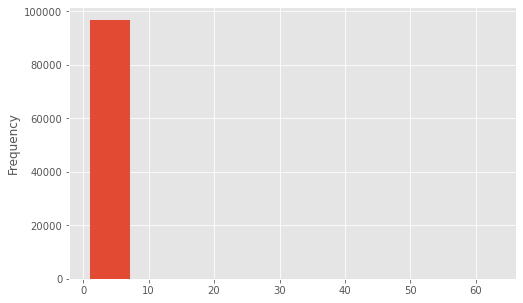

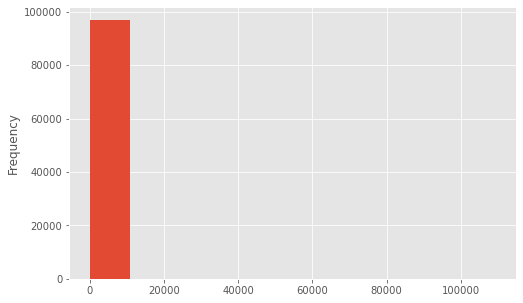

In [69]:
plt.figure(figsize=(8,5))
df['recency'].plot.hist()  

plt.figure(figsize=(8,5))
df['frequency'].plot.hist()

plt.figure(figsize=(8,5))
df['monetary_value'].plot.hist()

### 4.2.1 Tratamiento de outliers
Para encontrar el monetary value sumamos todos los pedidos realizados por cada cliente.

In [70]:
# Funcion para el tratamiento de los outliers
def outlier_treatment(df):
    numerical_columns = df.select_dtypes(include=['int32','int64', 'float64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3-Q1
        df.loc[ df[column] > (1.5*IQR), column ] = ( 1.5*IQR )
        df.loc[ df[column] < (-1.5*IQR), column] = ( -1.5*IQR )

In [71]:
outlier_treatment(df_rm)
df_rm.describe()

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alain/miniconda3/envs/ross/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

recency  monetary_value
count  96944.000000    96944.000000
mean     212.992527      119.063105
std      114.594679       62.039853
min        0.000000        9.590000
25%      115.000000       63.000000
50%      219.000000      110.000000
75%      348.000000      197.020000
max      349.500000      201.030000

In [74]:
df_rm.copy()

recency  monetary_value
0        331.0           38.71
1        349.5           37.77
2        349.5           37.77
3        309.0           44.09
4        349.5          201.03
...        ...             ...
96939     48.0           52.57
96940    105.0           66.38
96941     77.0           31.42
96942     22.0          201.03
96943    349.5          114.90

[96944 rows x 2 columns]

### 4.2.2 Normalizacion

In [72]:
df_rm_normal = df_rm.copy()

scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler.fit(df_rm_normal)
df_rm_normal = scaler.transform(df_rm_normal)

df_rm_normal = pd.DataFrame(df_rm_normal, index=df_rm.index)
df_rm_normal.columns=['recency', 'monetary_value']

# Check result after standardising
df_rm_normal.describe()

recency  monetary_value
count  9.694400e+04    9.694400e+04
mean   5.980802e-17    6.684426e-17
std    1.000005e+00    1.000005e+00
min   -1.858669e+00   -1.764570e+00
25%   -8.551272e-01   -9.036674e-01
50%    5.242394e-02   -1.460860e-01
75%    1.178136e+00    1.256568e+00
max    1.191226e+00    1.321204e+00

### 4.2.3 Clusterizacion

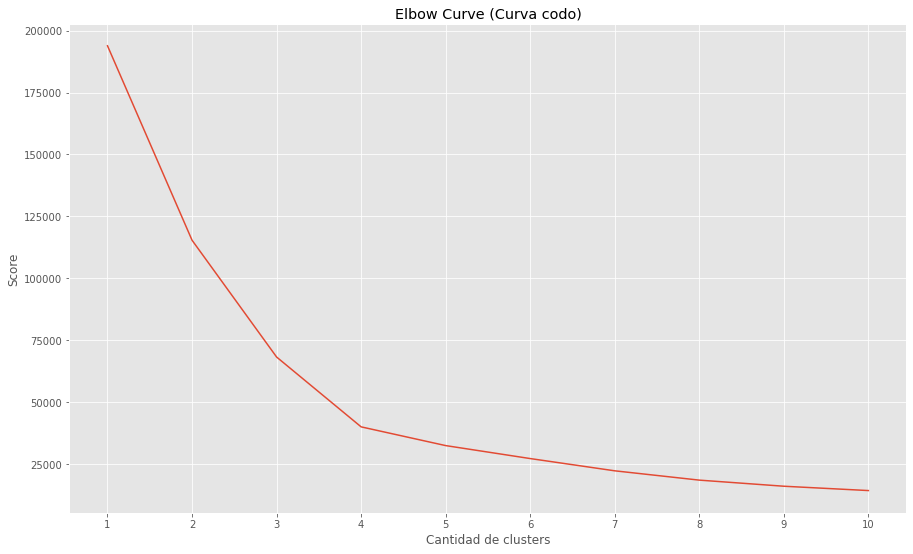

In [73]:
X=df_rm_normal.copy()
Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(X).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El gráfico nos muestra que el número ideal de clusters es 5.

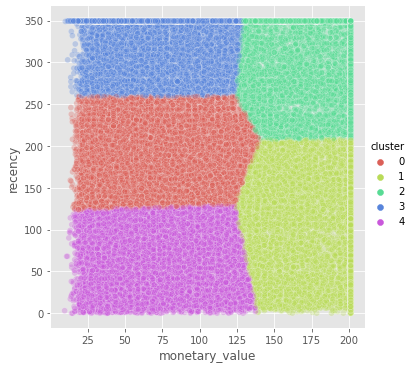

In [74]:
# KMeans
X=df_rm_normal.copy()
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(X)

X['Labels_KMeans'] = model.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rm_cluster5 = df_rm.copy()
rm_cluster5 = pd.concat([rm_cluster5, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 5),
            height=5, data=rm_cluster5)




In [75]:
rm_cluster5.groupby('cluster')['recency','monetary_value'].mean()

<ipython-input-75-e651e520c087>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  monetary_value
cluster                            
0        190.746767       70.979166
1        106.958094      184.583324
2        309.249142      183.628733
3        328.315485       70.512671
4         62.603723       72.714816

In [76]:
rm_cluster5['cluster'].value_counts()

3    23513
2    21552
1    19520
0    16779
4    15580
Name: cluster, dtype: int64

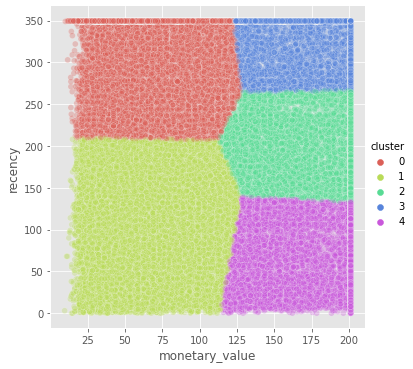

In [77]:
# MiniBatchKMeans
X=df_rm_normal.copy()

miniBatchKMean = MiniBatchKMeans(n_clusters=5, random_state=0, batch_size=100)

model = miniBatchKMean.fit(X)

X['Labels_KMeans'] = model.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rm_cluster5 = df_rm.copy()
rm_cluster5 = pd.concat([rm_cluster5, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 5),
            height=5, data=rm_cluster5)

In [78]:
# Incremental k-means 

from river import cluster
from river import metrics

X = df_rm_normal.iloc[0:50]

incremental_kmeans = cluster.KMeans(n_clusters=5, halflife=0.4, sigma=3, seed=0)
metric_ssw = metrics.cluster.SSW()
metric_cohesion = metrics.cluster.Cohesion()
metric_separation = metrics.cluster.Separation()
metric_ssb = metrics.cluster.SSB()
metric_bic = metrics.cluster.BIC()
metric_silhouette = metrics.cluster.Silhouette()
metric_xieBeni = metrics.cluster.XieBeni()

for row in X.to_dict('records'):
    incremental_kmeans = incremental_kmeans.learn_one(row)
    prediction = incremental_kmeans.predict_one(row)
   
    metric_ssw = metric_ssw.update(row, prediction, incremental_kmeans.centers)
    metric_cohesion = metric_cohesion.update(row, prediction, incremental_kmeans.centers)
    metric_separation = metric_separation.update(row, prediction, incremental_kmeans.centers)
    metric_ssb = metric_ssb.update(row, prediction, incremental_kmeans.centers)
    metric_bic = metric_bic.update(row, prediction, incremental_kmeans.centers)
    metric_silhouette = metric_silhouette.update(row, prediction, incremental_kmeans.centers)
    metric_xieBeni = metric_xieBeni.update(row, prediction, incremental_kmeans.centers)
    
prediction = incremental_kmeans.predict_one({'recency': 1.1912261428503317, 'monetary_value': 0.5009208384397379})    
print('Predicion cluster nro:',prediction)
print()
print('Metrica', metric_ssw)
print('Mas grande es mejor: ', metric_ssw.bigger_is_better)
print()
print('Metrica', metric_cohesion)
print('Mas grande es mejor:', metric_cohesion.bigger_is_better)
print()
print('Metrica', metric_separation)
print('Mas grande es mejor:', metric_separation.bigger_is_better)
print()
print('Metrica', metric_ssb)
print('Mas grande es mejor:', metric_ssb.bigger_is_better)
print()
print('Metrica', metric_bic)
print('Mas grande es mejor:', metric_bic.bigger_is_better)
print()
print('Metrica', metric_silhouette)
print('Mas grande es mejor:', metric_silhouette.bigger_is_better)
print()
print('Metrica', metric_xieBeni)
print('Mas grande es mejor:', metric_xieBeni.bigger_is_better)




Predicion cluster nro: 1

Metrica SSW: 0.427375
Mas grande es mejor:  False

Metrica Cohesion: 0.450029
Mas grande es mejor: False

Metrica Separation: 2.627278
Mas grande es mejor: True

Metrica SSB: 1.41907
Mas grande es mejor: True

Metrica BIC: 47.743561
Mas grande es mejor: True

Metrica Silhouette: 0.165476
Mas grande es mejor: False

Metrica XieBeni: 0.205456
Mas grande es mejor: False


In [79]:
centers_df = pd.DataFrame(incremental_kmeans.centers).transpose()
centers_df

recency  monetary_value
0  2.107002       -3.031917
1  0.112742        1.212392
2 -0.904352       -0.969265
3  0.528597       -1.132931
4 -1.509531        1.161463

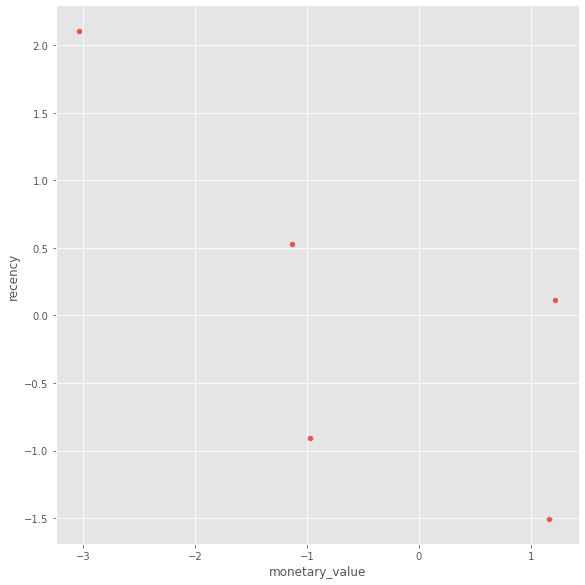

In [80]:
sns.relplot(x="monetary_value", y="recency", alpha=.9, height=8, data=centers_df)

In [81]:
X = df_rm_normal.iloc[100:7500]


for row in X.to_dict('records'):
    incremental_kmeans = incremental_kmeans.learn_one(row)
    prediction = incremental_kmeans.predict_one(row)
    metric_ssw = metric_ssw.update(row, prediction, incremental_kmeans.centers)
    metric_cohesion = metric_cohesion.update(row, prediction, incremental_kmeans.centers)
    metric_separation = metric_separation.update(row, prediction, incremental_kmeans.centers)
    metric_ssb = metric_ssb.update(row, prediction, incremental_kmeans.centers)
    metric_bic = metric_bic.update(row, prediction, incremental_kmeans.centers)
    metric_silhouette = metric_silhouette.update(row, prediction, incremental_kmeans.centers)
    metric_xieBeni = metric_xieBeni.update(row, prediction, incremental_kmeans.centers)
    
prediction = incremental_kmeans.predict_one({'recency': 1.1912261428503317, 'monetary_value': 0.5009208384397379})    
print('Predicion cluster nro:',prediction)
print()
print('Metrica', metric_ssw)
print('Mas grande es mejor: ', metric_ssw.bigger_is_better)
print()
print('Metrica', metric_cohesion)
print('Mas grande es mejor:', metric_cohesion.bigger_is_better)
print()
print('Metrica', metric_separation)
print('Mas grande es mejor:', metric_separation.bigger_is_better)
print()
print('Metrica', metric_ssb)
print('Mas grande es mejor:', metric_ssb.bigger_is_better)
print()
print('Metrica', metric_bic)
print('Mas grande es mejor:', metric_bic.bigger_is_better)
print()
print('Metrica', metric_silhouette)
print('Mas grande es mejor:', metric_silhouette.bigger_is_better)
print()
print('Metrica', metric_xieBeni)
print('Mas grande es mejor:', metric_xieBeni.bigger_is_better)


Predicion cluster nro: 2

Metrica SSW: 0.117239
Mas grande es mejor:  False

Metrica Cohesion: 0.281737
Mas grande es mejor: False

Metrica Separation: 2.584629
Mas grande es mejor: True

Metrica SSB: 2.578316
Mas grande es mejor: True

Metrica BIC: 56,080.857234
Mas grande es mejor: True

Metrica Silhouette: 0.106684
Mas grande es mejor: False

Metrica XieBeni: 0.032807
Mas grande es mejor: False


In [82]:
centers_df = pd.DataFrame(incremental_kmeans.centers).transpose()
centers_df

recency  monetary_value
0  2.107002       -3.031917
1 -0.735722       -1.212935
2  0.811019        0.933408
3 -1.476577        1.082647
4  1.176519       -1.386375

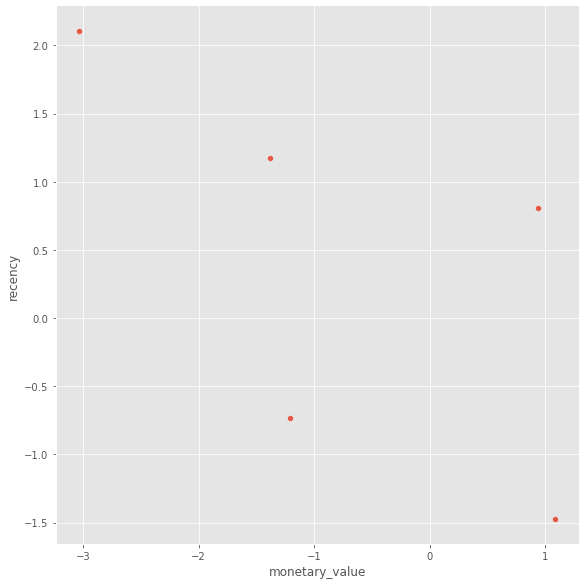

In [83]:
sns.relplot(x="monetary_value", y="recency", alpha=.9, height=8, data=centers_df)

### 4.2.4 Descripción de Clusters

<Figure size 1080x648 with 0 Axes>

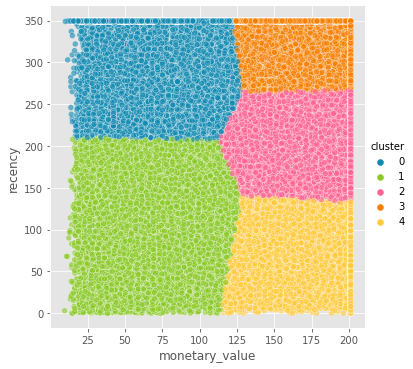

In [84]:
df_cluster = df.copy()
outlier_treatment(df_cluster)
cluster_label = rm_cluster5['cluster']
df_cluster = pd.concat([df_cluster, cluster_label], axis=1, sort = False)

plt.figure(figsize = (15,9))
colors = ['#118ab2', '#8ac926','#ff6392','#f77f00','#ffca3a']
ax = sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.6,palette=colors,
            height=5, data=df_cluster)
plt.show()

In [85]:
df_cluster['cluster'].value_counts(normalize=True)*100

0    29.316925
1    25.416735
3    17.970168
4    14.000866
2    13.295305
Name: cluster, dtype: float64

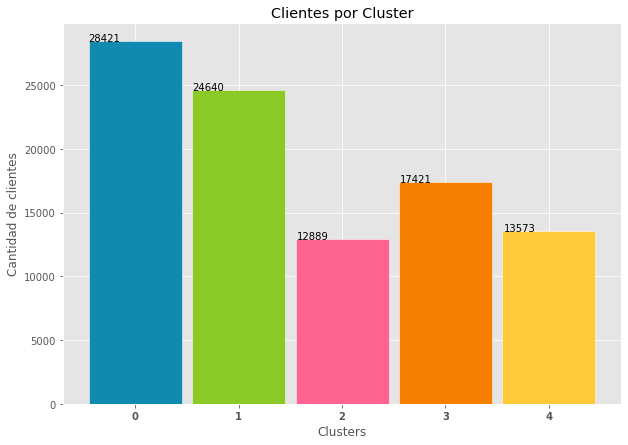

In [86]:
colors = ['#118ab2', '#8ac926','#ff6392','#f77f00','#ffca3a']

plt.figure(figsize=(10,7))
ax = df_cluster['cluster'].value_counts().sort_index().plot(kind='bar',width=0.9,color=colors, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
    
plt.xlabel('Clusters')
plt.ylabel('Cantidad de clientes')
plt.title('Clientes por Cluster')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

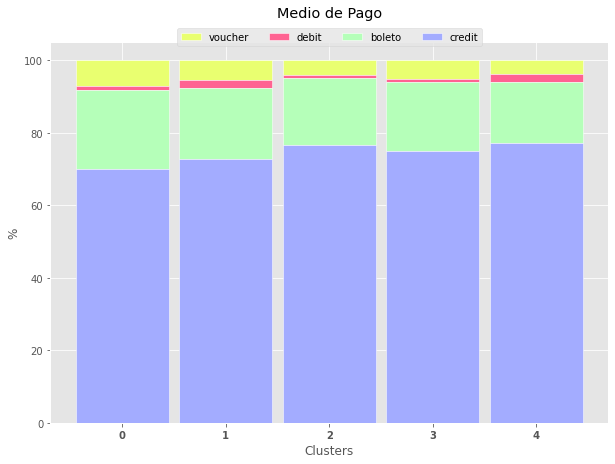

In [87]:
all_data_cluster = all_data.merge(df_cluster, on='customer_id', how='inner')

pay = all_data_cluster.groupby('cluster')['payment_type'].value_counts()
pay = pay.unstack()
pay.reset_index()

clusters = (['0','1','2','3','4'])
boleto = np.array(pay['boleto'].unique())
credit = np.array(pay['credit_card'].unique())
debit = np.array(pay['debit_card'].unique())
voucher = np.array(pay['voucher'].unique())


total = boleto+credit+debit+voucher
proportion_voucher = np.true_divide(voucher,total)*100
proportion_debit = np.true_divide(debit,total)*100
proportion_boleto = np.true_divide(boleto,total)*100
proportion_credit = np.true_divide(credit,total)*100


colors = ['#a3acff', '#b5ffb9','#ff6392','#FFD670','#E9FF70']

# The position of the bars on the x-axis
r = range(len(clusters))

barWidth = 0.9
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, proportion_voucher, bottom=proportion_debit+proportion_boleto+proportion_credit, color=colors[4], edgecolor='white', width=barWidth, label="voucher")
ax3 = plt.bar(r, proportion_debit, bottom = proportion_boleto+proportion_credit, color=colors[2], edgecolor='white', width=barWidth, label='debit')
ax4 = plt.bar(r, proportion_boleto, bottom = proportion_credit, color=colors[1], edgecolor='white', width=barWidth, label='boleto')
ax5 = plt.bar(r, proportion_credit , color=colors[0], edgecolor='white', width=barWidth, label='credit')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True)
plt.xticks(r, clusters, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('%')
plt.title('Medio de Pago', pad=25)
plt.show()

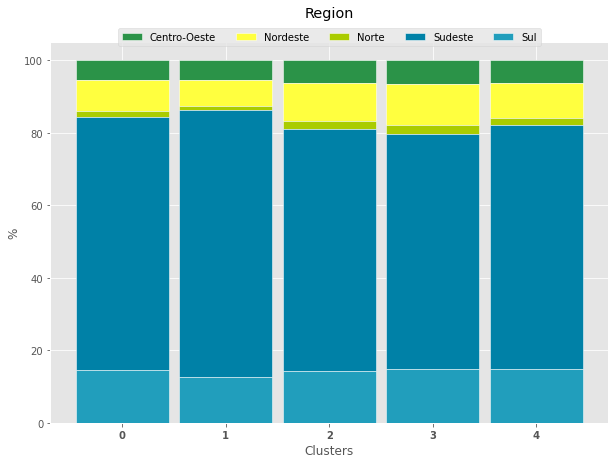

In [88]:
region = all_data_cluster.groupby('cluster')['customer_regiao'].value_counts().unstack().reset_index()

clusters = (['0','1','2','3','4'])
centro = np.array(region['Centro-Oeste'].unique())
nordeste = np.array(region['Nordeste'].unique())
norte = np.array(region['Norte'].unique())
sudeste = np.array(region['Sudeste'].unique())
sul = np.array(region['Sul'].unique())


total = centro+nordeste+norte+sudeste+sul
proportion_centro = np.true_divide(centro,total)*100
proportion_nordeste = np.true_divide(nordeste,total)*100
proportion_norte = np.true_divide(norte,total)*100
proportion_sudeste = np.true_divide(sudeste,total)*100
proportion_sul = np.true_divide(sul,total)*100

colors = ['#2b9348', '#ffff3f','#aacc00','#0081a7','#219ebc']

# The position of the bars on the x-axis
r = range(len(clusters))

barWidth = 0.9
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, proportion_centro, bottom=proportion_nordeste+proportion_norte+proportion_sudeste+proportion_sul, color=colors[0], edgecolor='white', width=barWidth, label="Centro-Oeste")
ax2 = plt.bar(r, proportion_nordeste, bottom=proportion_norte+proportion_sudeste+proportion_sul, color=colors[1], edgecolor='white', width=barWidth, label='Nordeste')
ax3 = plt.bar(r, proportion_norte, bottom = proportion_sudeste+proportion_sul, color=colors[2], edgecolor='white', width=barWidth, label='Norte')
ax3 = plt.bar(r, proportion_sudeste,  bottom = proportion_sul, color=colors[3], edgecolor='white', width=barWidth, label='Sudeste')
ax4 = plt.bar(r, proportion_sul, color=colors[4], edgecolor='white', width=barWidth, label='Sul')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True)
plt.xticks(r, clusters, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('%')
plt.title('Region', pad=25)
plt.show()